In [28]:
#Necesary libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import cvlib
import joblib

def extent(cnt):
    """ Receives the dims of a contour and returns its values
        
    Args:
        cnt (np array): The contour

    Returns:
        res (np array): The dimentions
    """

    area = cv.contourArea(cnt)
    x,y,w,h = cv.boundingRect(cnt)
    rect_area = w*h
    res = float(area)/rect_area
    return res

plt.style.use(['dark_background'])
%matplotlib inline

### Preparation of the plate

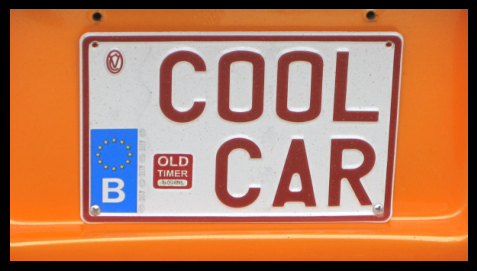

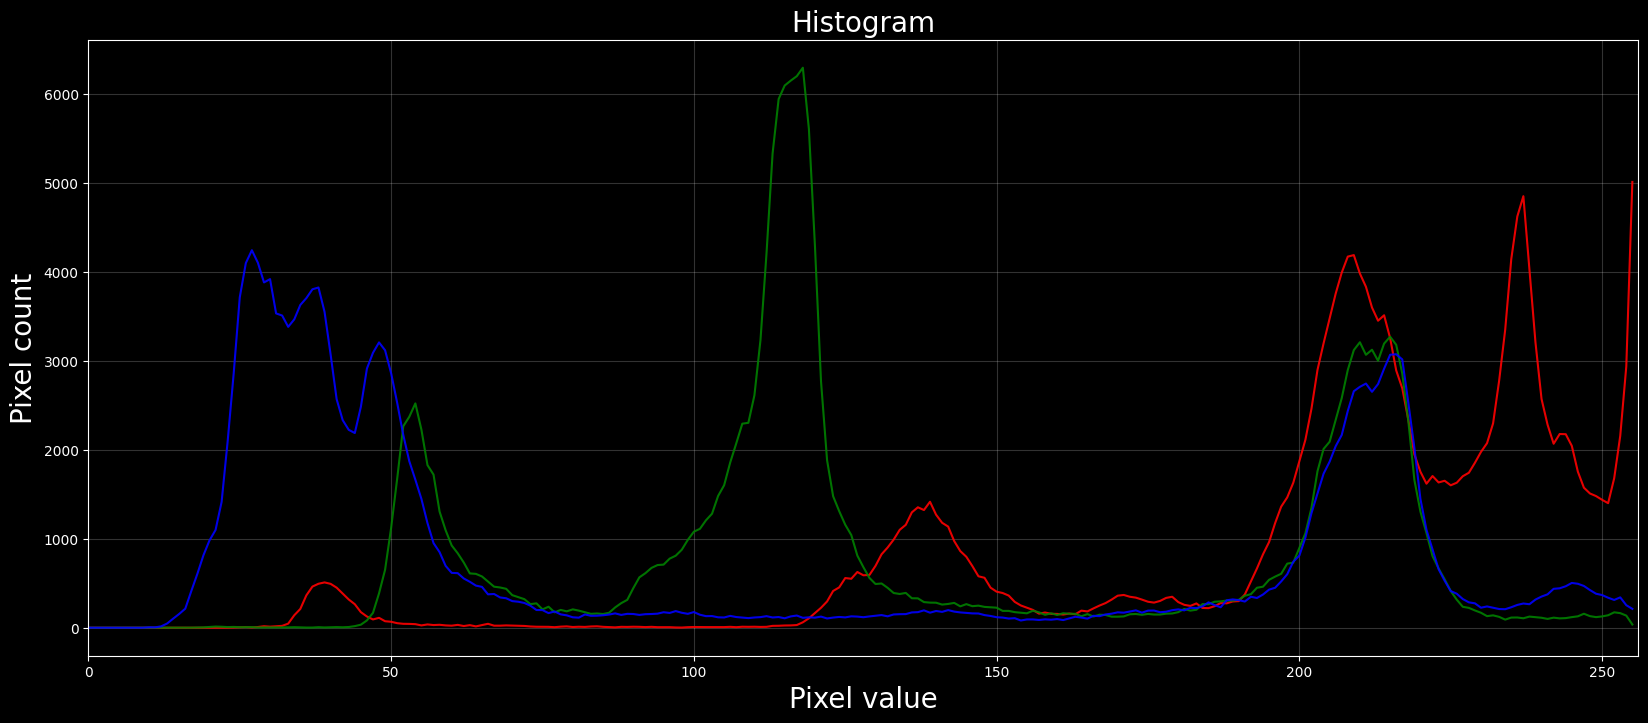

In [29]:
img_raw = cv.imread('LicencePlates/images26.jpg', cv.IMREAD_COLOR)
img_raw = cv.cvtColor(img_raw, cv.COLOR_BGR2RGB)
cvlib.imgview(img_raw)
cvlib.colorhist(img_raw)

In [30]:
# Variances expresed in the prev graf to get the lowest
red = np.var(img_raw[:,:,0])
green = np.var(img_raw[:,:,1])
blue = np.var(img_raw[:,:,2])

if blue < green and blue < red:
    imgray = img_raw[:,:,2]
elif green < blue and green < red:
    imgray = img_raw[:,:,1]
else:
    imgray = img_raw[:,:,0]

In [31]:
# Normalization of the image
_, imgray = cv.threshold(imgray, 210, 255,cv.THRESH_TRUNC)
_, imgray = cv.threshold(imgray, 60, 255,cv.THRESH_TOZERO)
imgray = cv.GaussianBlur(imgray, (5,5), 10)

In [32]:
# Getting the contours
thresh = cv.adaptiveThreshold(imgray, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,17,1)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
print("# Objects:", len(contours))

# Objects: 608


In [33]:
# Getting the plate searching the most rectangular one
img = img_raw.copy() 
m, n = 0, 0
for i, contorn in enumerate(contours):
    ext = extent(contorn)
    ext = round(ext, 2)
    x,y,w,h = cv.boundingRect(contorn)
    img = cv.drawContours(img,[contorn],0,(0,255,0),2)
    img = cv.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
    if (ext > m):
        n = i 
        m = ext

In [34]:
# Plate identified
x, y, w, h = cv.boundingRect(contours[n])
xp, yp = x, y
objective = img_raw[y:y+h, x:x+w]
cv.rectangle(img_raw, (x, y), (x + w, y + h), (0, 255, 0), 4)
print(objective.shape)

(244, 418, 3)


### Extracting all the components in the plate

In [35]:
# Mapping the plate and getting shapes
h, w, _ = objective.shape
c_w = int(0.04 * w)
c_h = int(0.11 * h)
x1 = c_w
y1 = c_h
x2 = w - c_w
y2 = h - c_h
img = objective[y1:y2, x1:x2]

In [36]:
# Getting the original picture with the new coordinates
plate = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plate = cv.GaussianBlur(plate, (7,7), 1)
hist = cv.calcHist([plate], [0], None, [256], [0, 256])

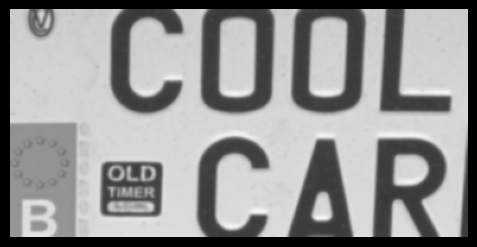

In [37]:
cvlib.imgview(plate)

In [38]:
# Binarizing
glow = sum(hist[100:])
threshold = 0.5
if glow / sum(hist) > threshold:
    img_bin = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 33, 5)
else:
    img_bin = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 23, -2)

In [39]:
# Cleaning the new image
kernel = np.ones((3, 3), np.uint8)
img_bin = cv.erode(img_bin, kernel, iterations=1)
components = cv.connectedComponentsWithStats(img_bin, connectivity=4)

In [40]:
# Getting the contours of all the elements
final = img.copy()
contours = []
w_med = []
h_med = []

for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    contours.append(area)
    
mindex = np.argmax(contours)
mvalue = contours[mindex] * 0.10

In [41]:
# Getting all the contours in the cutted image
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            w_med.append(w)
            h_med.append(h)

if len(h_med) != 0:
    max_height = (sum(h_med)/len(h_med)) * 1.40
    min_height = (sum(h_med)/len(h_med)) * 0.75
else:
    max_height = plate.shape[0]
    min_height = 0

In [42]:
components[2]

array([[    0,     0,   386,   192, 56342],
       [   16,     0,    21,    24,   196],
       [   86,     0,    59,    87,  2019],
       [  162,     0,    60,    87,  2594],
       [  238,     0,    60,    87,  2520],
       [  313,     0,    58,    86,  1622],
       [   53,     4,     1,     1,     1],
       [  361,    25,     1,     1,     1],
       [   72,    48,     2,     1,     2],
       [    0,    97,    55,    95,  1258],
       [   27,   109,     2,     4,     5],
       [  159,   109,    59,    83,  1844],
       [  235,   110,    53,    82,  2004],
       [  307,   110,    60,    82,  2491],
       [   38,   112,     1,     3,     3],
       [  381,   112,     5,    80,   217],
       [   17,   113,     1,     2,     2],
       [   25,   113,     2,     1,     2],
       [   16,   115,     1,     1,     1],
       [   37,   115,     1,     1,     1],
       [    9,   119,     1,     3,     3],
       [   42,   119,     6,     4,    10],
       [    8,   122,     1,    

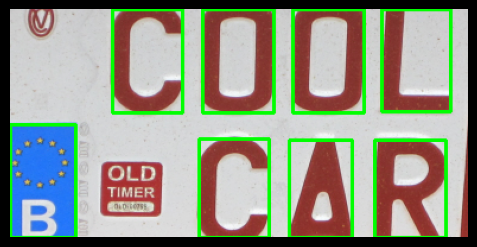

In [43]:
# Identifying the letters in the plate
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            if h > min_height and h < max_height:
                cv.rectangle(final, (x, y), (x + w, y + h), (0, 255, 0), 2)

cvlib.imgview(final)

### Getting the digits of the plate

In [44]:
# Putting the letters in black and everything else in white
glow = sum(hist[100:])
threshold = 0.5
if glow / sum(hist) > threshold:
    img_bin2 = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 33, 5)
else:
    img_bin2 = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 23, -2)

In [45]:
# Getting the position of the letters
letters = []
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            if h > min_height and h < max_height:
                letters.append([x, y, w, h, area])

In [46]:
letters

[[86, 0, 59, 87, 2019],
 [162, 0, 60, 87, 2594],
 [238, 0, 60, 87, 2520],
 [313, 0, 58, 86, 1622],
 [0, 97, 55, 95, 1258],
 [159, 109, 59, 83, 1844],
 [235, 110, 53, 82, 2004],
 [307, 110, 60, 82, 2491]]

In [47]:
# Ordering the letters
letters_ordered = []
temp = []

for i in range(len(letters)+1):
    if i == len(letters):
        sorter = lambda x: (x[0])
        temp = sorted(temp, key=sorter)
        for j in range(len(temp)):
            letters_ordered.append(temp[j])
    else:
        if len(temp) == 0:
            temp.append(letters[i])
        else:
            if (letters[i][1] - letters[i-1][1]) < 10:
                temp.append(letters[i])
            else:
                sorter = lambda x: (x[0])
                temp = sorted(temp, key=sorter)
                for j in range(len(temp)):
                    letters_ordered.append(temp[j])
                temp = []
                temp.append(letters[i])

In [48]:
letters_ordered

[[86, 0, 59, 87, 2019],
 [162, 0, 60, 87, 2594],
 [238, 0, 60, 87, 2520],
 [313, 0, 58, 86, 1622],
 [0, 97, 55, 95, 1258],
 [159, 109, 59, 83, 1844],
 [235, 110, 53, 82, 2004],
 [307, 110, 60, 82, 2491]]

In [49]:
# Removing elements that are not letters but the cutter told that they are

ared = []
ablue = []
agreen = []
for i in range(len(letters_ordered)):
    x, y, w, h, area = letters_ordered[i]
    red = np.var(img[y:y+h, x:x+w][:,:,0])
    green = np.var(img[y:y+h, x:x+w][:,:,1])
    blue = np.var(img[y:y+h, x:x+w][:,:,2])
    if blue < green and blue < red:
        ablue.append(letters_ordered[i])
    elif green < blue and green < red:
        agreen.append(letters_ordered[i])
    else:
        ared.append(letters_ordered[i])

if len(ablue) == 1:
    letters_ordered.remove(ablue[0])
if len(ared) == 1:
    letters_ordered.remove(ared[0])
if len(agreen) == 1:
    letters_ordered.remove(agreen[0])

In [50]:
# Saving the letters for identification
letters = []
for i in range(len(letters_ordered)):
    x, y, w, h, area = letters_ordered[i]
    if area >= mvalue:
        if h > w:
            if h > min_height and h < max_height:
                letra = img_bin2[y:y+h, x:x+w]
                letra = np.pad(letra, 5, 'constant', constant_values=255)
                new_size = cv.resize(letra, dsize=(75, 100), interpolation=cv.INTER_LANCZOS4)
                flatted = new_size.flatten()
                letters.append(flatted)

In [51]:
# Using the model to make the prediction
model = joblib.load("model.sav")
placa = ""

letra = model.predict(letters)
for i in range(len(letra)):
    placa = placa + letra[i]

### Final result

In [52]:
font = cv.FONT_HERSHEY_SIMPLEX
org = (xp,yp - 5)
fontScale = 1
color = (0, 255, 0)
thickness = 2

entregable = cv.putText(img_raw, placa, org, font, 
                   fontScale, color, thickness, cv.LINE_AA)

Placa: C00LCAR


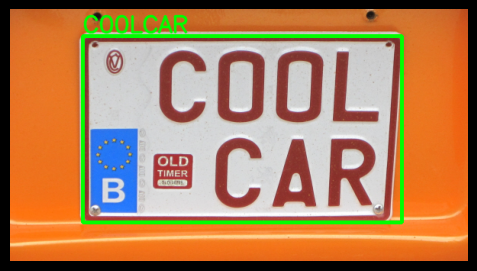

In [53]:
cvlib.imgview(entregable)
print(f"Placa: {placa}")